In [301]:
import tensorflow as tf
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization
import seaborn as sns

In [302]:
data = pl.read_csv('SPAM text message 20170820 - Data.csv')

In [303]:
data

Category,Message
str,str
"""ham""","""Go until juron…"
"""ham""","""Ok lar... Joki…"
"""spam""","""Free entry in …"
"""ham""","""U dun say so e…"
"""ham""","""Nah I don't th…"
"""spam""","""FreeMsg Hey th…"
"""ham""","""Even my brothe…"
"""ham""","""As per your re…"
"""spam""","""WINNER!! As a …"


In [304]:
data.groupby('Category').count()

Category,count
str,u32
"""spam""",747
"""ham""",4825


In [305]:
ham_msg = data.filter(pl.col('Category') == 'ham')
spam_msg = data.filter(pl.col('Category') == 'spam')

In [306]:
#randomly taking data from ham_ msg
ham_msg = ham_msg.sample(n=len(spam_msg))

In [307]:
print(ham_msg.shape, spam_msg.shape)

(747, 2) (747, 2)


In [308]:
data

Category,Message
str,str
"""ham""","""Go until juron…"
"""ham""","""Ok lar... Joki…"
"""spam""","""Free entry in …"
"""ham""","""U dun say so e…"
"""ham""","""Nah I don't th…"
"""spam""","""FreeMsg Hey th…"
"""ham""","""Even my brothe…"
"""ham""","""As per your re…"
"""spam""","""WINNER!! As a …"


In [309]:
balanced_data = ham_msg.vstack(spam_msg)
balanced_data = balanced_data.with_columns(
    pl.when(pl.col("Category") == 'spam').then(1).otherwise(0).alias('Category')
)

In [310]:
balanced_data

Category,Message
i32,str
0,"""When did dad g…"
0,"""Haha... They c…"
0,"""Hey, a guy I k…"
0,"""Let Ur Heart B…"
0,"""Princess, i li…"
0,"""As per your re…"
0,"""Imagine Life W…"
0,"""Gam gone after…"
0,"""Am in gobi art…"


In [311]:
X_train, X_test, Y_train, Y_test = train_test_split(
    balanced_data['Message'], 
    balanced_data['Category'],
    test_size=0.2,
    random_state=42
)

In [312]:
X_train = np.array(X_train, dtype=np.chararray)
X_test = np.array(X_test, dtype=np.chararray)
X_train

array(["Sorry, I'll call later",
       "Good morning, my boytoy! How's those yummy lips ? Where's my sexy buns now ? What do you do ? Do you think of me ? Do you crave me ? Do you need me ?",
       'Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?',
       ...,
       'You have an important customer service announcement from PREMIER. Call FREEPHONE 0800 542 0578 now!',
       'URGENT! Your Mobile number has been awarded with a £2000 prize GUARANTEED. Call 09061790126 from land line. Claim 3030. Valid 12hrs only 150ppm',
       'How come it takes so little time for a child who is afraid of the dark to become a teenager who wants to stay out all night?'],
      dtype=object)

In [313]:
max_features = 5000  # Maximum vocab size.
max_len = max([len(message) for message in balanced_data['Message']])  # Sequence length to pad the outputs to.

# Create the layer.
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=max_len
)
vectorize_layer.adapt(X_test)
vectorizd_X_test = vectorize_layer(X_test)

vectorize_layer.adapt(X_train)
vectorizd_X_train = vectorize_layer(X_train)
vectorizd_X_train

<tf.Tensor: shape=(1195, 790), dtype=int64, numpy=
array([[ 156,   99,    5, ...,    0,    0,    0],
       [ 102,  304,   30, ...,    0,    0,    0],
       [ 344, 1598,   76, ...,    0,    0,    0],
       ...,
       [   3,   19,  118, ...,    0,    0,    0],
       [  69,    8,   32, ...,    0,    0,    0],
       [  76,  117,   41, ...,    0,    0,    0]])>

In [314]:
Y_train = np.array(Y_train, dtype=np.int64)
Y_test = np.array(Y_test, dtype=np.int64)

In [315]:
#model
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(64, activation='relu', input_shape=(max_len,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

In [316]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
    optimizer='adam'
)

In [317]:
history=model.fit(
    vectorizd_X_train,
    Y_train,
    epochs=100,
    batch_size=32
)

Epoch 1/100


/home/mohamed/anaconda3/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 [==============================] - 7s 15ms/step - loss: 13.1437 - accuracy: 0.6402
Epoch 2/100
38/38 [==============================] - 1s 22ms/step - loss: 3.8744 - accuracy: 0.7473
Epoch 3/100
38/38 [==============================] - 1s 20ms/step - loss: 1.6454 - accuracy: 0.8126
Epoch 4/100
38/38 [==============================] - 1s 18ms/step - loss: 1.0157 - accuracy: 0.8552
Epoch 5/100
38/38 [==============================] - 1s 20ms/step - loss: 0.7487 - accuracy: 0.8661
Epoch 6/100
38/38 [==============================] - 1s 17ms/step - loss: 0.3901 - accuracy: 0.9146
Epoch 7/100
38/38 [==============================] - 1s 22ms/step - loss: 0.2529 - accuracy: 0.9356
Epoch 8/100
38/38 [==============================] - 1s 19ms/step - loss: 0.2120 - accuracy: 0.9448
Epoch 9/100
38/38 [==============================] - 1s 19ms/step - loss: 0.1484 - accuracy: 0.9640
Epoch 10/100
38/38 [==============================] - 1s 17ms/step - loss: 0.1825 - accuracy: 0.9598
Epoch 11/1

In [318]:
model.evaluate(
    vectorizd_X_test,
    Y_test
)

10/10 [==============================] - 0s 5ms/step - loss: 3.0534 - accuracy: 0.6421


[3.053405284881592, 0.6421404480934143]

Text(0.5, 0, 'epoch')

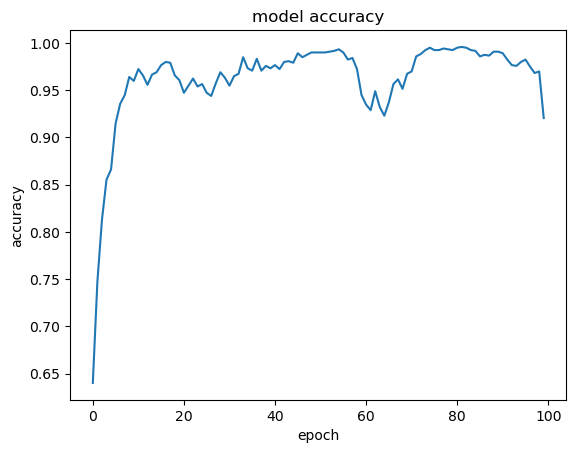

In [319]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [320]:
predict_msg = [
    "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
    "Ok lar... Joking wif u oni...",
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In [321]:
vectorize_layer.adapt(predict_msg)
vectorizd_predict_msg = vectorize_layer(predict_msg)

model.predict(vectorizd_predict_msg)

1/1 [==============================] - 0s 317ms/step


array([[0.28914064],
       [0.1738804 ],
       [0.33571908]], dtype=float32)